# Спектограмму будем строить с помощью двух библиотек Librosa (CPU) и Nvidia Dali (GPU)

# Импортируем нужные библиотеки

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali as dali
import nvidia.dali.types as types
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

# Загружаем аудиофайл для последующего построения cпектрограммы (Для примера возьмем трек исполнителя KIDKA$H - Cheetos)

In [2]:
file = "/content/sample_data/KIDKASH - Cheetos.mp3"

# Загружаем файл

In [3]:
y, sr = librosa.load(file)

In [4]:
n_fft = 2048
hop_length = 512
win_length = 2048

# Строим спектрограмму с помощью библиотеки Librosa

In [5]:
librosa_start_time = time.time()
spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann')) ** 2
librosa_end_time = time.time() - librosa_start_time

In [6]:
spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)

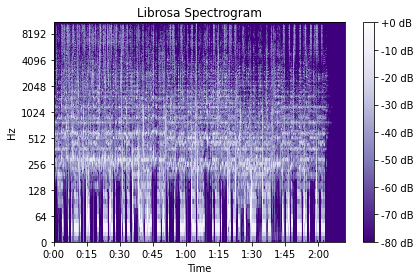

In [7]:
librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time', hop_length=512, cmap='Purples_r')
plt.title('Librosa Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Построение спектрограммы при помощи NVIDIA Dali

In [8]:
audio_data = np.array(y, dtype=np.float32)

@pipeline_def
def spectrogram_pipe(nfft, window_length, window_step, device='gpu'):
    audio = types.Constant(device=device, value=audio_data)
    spectrogram = fn.spectrogram(audio, device=device, nfft=nfft,
                                 window_length=window_length,
                                 window_step=window_step)
    return spectrogram

In [9]:
nvidia_dali_start_time = time.time()
pipe = spectrogram_pipe(device='gpu', batch_size=1, num_threads=3, device_id=0, nfft=n_fft, window_length=win_length, window_step=512)
pipe.build()
outputs = pipe.run()
spectrogram_dali = outputs[0][0].as_cpu()
nvidia_dali_end_time = time.time() - nvidia_dali_start_time

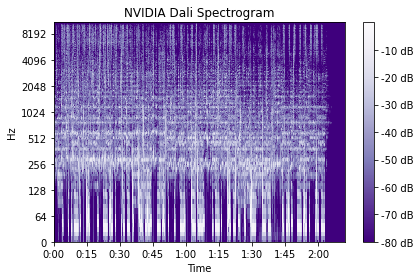

In [13]:
spectrogram_dali_db = librosa.power_to_db(spectrogram_dali, ref=np.max)
librosa.display.specshow(spectrogram_dali_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length, cmap='Purples_r')
plt.colorbar(format="%+2.0f dB")
plt.title('NVIDIA Dali Spectrogram')
plt.tight_layout()
plt.show()

In [11]:
df = pd.DataFrame(columns=["Average error", "Time Librosa", "Time Dali", "Speed up"])
df = df.append({
    "Average error": np.mean(np.abs(spectrogram_dali_db - spectrogram_librosa_db)),
    "Time Librosa": librosa_end_time,
    "Time Dali": nvidia_dali_end_time,
    "Speed up": librosa_end_time/nvidia_dali_end_time
}, ignore_index=True)

In [12]:
df

,Average error,Time Librosa,Time Dali,Speed up
0,0.006674,0.210443,1.144063,0.183944
